- Testing Snorkel
- Increased max token length from 256 → 512 to reduce information loss.
- Switched to softer text cleaning to preserve punctuation and technical terms. 

## Setup

In [10]:
# Imports

import re
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
from tqdm import tqdm
import collections

In [11]:
# Paths

data_path = Path("../../data/short-raw-refs-abs")
table_path = Path("../../reports/tables")
figure_path = Path("../../reports/figures")
keywords_path = Path("../../keywords")
processed_abstracts_path = Path("../../data/processed/abstracts")

# Ensure directories exist
for p in [data_path, table_path, figure_path, keywords_path, processed_abstracts_path]:
    p.mkdir(parents=True, exist_ok=True)

print("All directories verified/created.")


All directories verified/created.


In [12]:
# Constants

CREATE_ABSTRACTS_DATASET = False

# Number of topics used for K-means
n_topics = 8

#### Create Abstracts dataset (only need to do this once)

In [13]:
# Helper: Clean Abstracts
# Basic text cleaning

# Light cleaning for model input: keep most of the original signal
def clean_text_for_model(text):
    if not isinstance(text, str):
        return ""

    # Remove Scopus-style copyright header at the very beginning
    text = re.sub(r"^©\s*\d{0,4}\s*the author\(s\)\s*", "", text, flags=re.IGNORECASE)

    # Optionally strip URLs and extra whitespace, but keep punctuation, numbers, etc.
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()


In [14]:
records = []

if CREATE_ABSTRACTS_DATASET:

    for folder in sorted(data_path.iterdir()):
        if not folder.is_dir():
            continue
        query_id = folder.name
        jsonl_files = list(folder.glob("*.jsonl"))
        for fp in jsonl_files:
            with fp.open("r", encoding="utf-8") as f:
                for line in f:
                    line = line.strip()
                    if not line:
                        continue
                    try:
                        rec = json.loads(line)
                    except json.JSONDecodeError:
                        continue

                    abs_txt = rec.get("abstract") or rec.get("description") or ""
                    if isinstance(abs_txt, list):
                        abs_txt = " ".join(str(x) for x in abs_txt if x)

                    # Cover date was not included in last script
                    records.append({
                        "query_id": query_id,
                        "eid": rec.get("eid"),
                        "doi": rec.get("doi"),
                        "title": rec.get("title"),
                        # "coverDate": rec.get("coverDate"),
                        "abstract": abs_txt.strip()
                    })

    df = pd.DataFrame(records)
    
    # Remove empty abstracts early
    df = df[df["abstract"].notna() & (df["abstract"].str.strip() != "")]
    df = df.reset_index(drop=True)
    
    # Clean abstracts
    df["clean_abs"] = df["abstract"].apply(clean_text_for_model)
    
    print(f"\nCollected {len(df)} abstracts from {len(df['query_id'].unique())} queries")

    # Save for later analysis
    out_path = processed_abstracts_path / "abstracts.csv"
    df.to_csv(out_path, index=False)
    print(f"Saved: {out_path}")


In [15]:
# Load dataframe with abstracts
# Only if it has been created earlier

if not CREATE_ABSTRACTS_DATASET:
    abstracts_path = processed_abstracts_path / "abstracts.csv"
    df = pd.read_csv(abstracts_path) 
    print(f"Loaded {len(df)} abstracts")


Loaded 32714 abstracts


In [16]:
df.head(2)

,query_id,eid,doi,title,abstract,clean_abs
0,ml_anomaly_detection_production,2-s2.0-105018574505,10.1016/j.measurement.2025.119261,Distillation anomaly and fault detection based...,© 2025 The Author(s)The detection of anomalies...,The detection of anomalies in production proce...
1,ml_anomaly_detection_production,2-s2.0-105019192533,10.1007/978-3-032-06118-8_30,From Lab to Factory: Pitfalls and Guidelines f...,"© The Author(s), under exclusive license to Sp...",", under exclusive license to Springer Nature S..."


## Analyze with Keywords (Supervised / Unsupervised / Reinforcement)

Each article is classified using keyword matching based on its cleaned abstract.
The classification is **multi-label**, meaning an article may be tagged as
supervised, unsupervised, and/or reinforcement learning depending on which
keywords appear as whole words in the text.

In [17]:
# Gather all keywords 

def load_keyword_file(path: Path) -> list[str]:
    keywords = []
    with path.open("r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith("#"):
                continue
            keywords.append(line.lower())
    return keywords


def load_all_keywords(base_dir: Path = keywords_path) -> dict[str, list[str]]:
    return {
        "supervised": load_keyword_file(base_dir / "supervised.txt"),
        "unsupervised": load_keyword_file(base_dir / "unsupervised.txt"),
        "reinforcement": load_keyword_file(base_dir / "reinforcement.txt"),
    }


ml_keywords = load_all_keywords()


In [18]:
# For each ML category, create a binary column (1/0) indicating
# whether any of that category's keywords appear in the cleaned abstract.
# (Uses word-boundary matching so e.g. 'supervised' does NOT match inside 'unsupervised')

def contains_keyword(text, keyword):
    # Escape keyword and enforce word boundaries (\b)
    pattern = rf"\b{re.escape(keyword)}\b"
    return re.search(pattern, text) is not None

for label in ml_keywords.keys():
    df[f"is_{label}"] = df["clean_abs"].apply(
        lambda t, lab=label: any(contains_keyword(str(t).lower(), w) for w in ml_keywords[lab])

    )
    
df.head(2)

,query_id,eid,doi,title,abstract,clean_abs,is_supervised,is_unsupervised,is_reinforcement
0,ml_anomaly_detection_production,2-s2.0-105018574505,10.1016/j.measurement.2025.119261,Distillation anomaly and fault detection based...,© 2025 The Author(s)The detection of anomalies...,The detection of anomalies in production proce...,True,True,False
1,ml_anomaly_detection_production,2-s2.0-105019192533,10.1007/978-3-032-06118-8_30,From Lab to Factory: Pitfalls and Guidelines f...,"© The Author(s), under exclusive license to Sp...",", under exclusive license to Springer Nature S...",True,True,False


In [19]:
# Create a column: "ml_type" that lists all categorys with True

def resolve_label(row):
    labels = []
    if row["is_supervised"]: labels.append("supervised")
    if row["is_unsupervised"]: labels.append("unsupervised")
    if row["is_reinforcement"]: labels.append("reinforcement")
    return labels or ["unknown"]

df["ml_type"] = df.apply(resolve_label, axis=1)

df.head()


,query_id,eid,doi,title,abstract,clean_abs,is_supervised,is_unsupervised,is_reinforcement,ml_type
0,ml_anomaly_detection_production,2-s2.0-105018574505,10.1016/j.measurement.2025.119261,Distillation anomaly and fault detection based...,© 2025 The Author(s)The detection of anomalies...,The detection of anomalies in production proce...,True,True,False,"[supervised, unsupervised]"
1,ml_anomaly_detection_production,2-s2.0-105019192533,10.1007/978-3-032-06118-8_30,From Lab to Factory: Pitfalls and Guidelines f...,"© The Author(s), under exclusive license to Sp...",", under exclusive license to Springer Nature S...",True,True,False,"[supervised, unsupervised]"
2,ml_anomaly_detection_production,2-s2.0-105016669957,10.1007/978-3-032-04200-2_5,Intelligent Defect Detection for Manufacturing...,"© The Author(s), under exclusive license to Sp...",", under exclusive license to Springer Nature S...",True,True,False,"[supervised, unsupervised]"
3,ml_anomaly_detection_production,2-s2.0-85218693791,10.1038/s41598-025-90810-w,Hybrid machine learning framework for predicti...,© The Author(s) 2025.The critical necessity fo...,2025.The critical necessity for sophisticated ...,True,True,False,"[supervised, unsupervised]"
4,ml_anomaly_detection_production,2-s2.0-105018301117,10.1016/j.comnet.2025.111753,BGP anomaly detection using the raw internet t...,© 2025 The AuthorsThe Border Gateway Protocol ...,© 2025 The AuthorsThe Border Gateway Protocol ...,False,True,False,[unsupervised]


In [20]:
# Frequency of each ML category
df["ml_type"].explode().value_counts()

ml_type
unknown          18854
supervised       10198
unsupervised      3945
reinforcement     2096
Name: count, dtype: int64

In [21]:
# Frequency for each query
df.explode("ml_type").groupby(["query_id", "ml_type"]).size().unstack(fill_value=0)

ml_type,reinforcement,supervised,unknown,unsupervised
query_id,,,,
ml_anomaly_detection_production,30,293,69,594
ml_automation,126,321,1138,150
ml_defect_detection,23,297,322,122
ml_manufacturing_optimization,330,1106,2399,307
ml_planning_production,252,784,1218,198
ml_plm,9,75,166,14
ml_predictive_maintenance,193,1571,2307,746
ml_process_control,221,1002,1867,363
ml_process_modeling,43,192,492,66


In [22]:
# Percentage of abstracts that mention each ML category
df[["is_supervised", "is_unsupervised", "is_reinforcement"]].mean()

is_supervised       0.311732
is_unsupervised     0.120591
is_reinforcement    0.064070
dtype: float64

<Axes: xlabel='ml_type'>

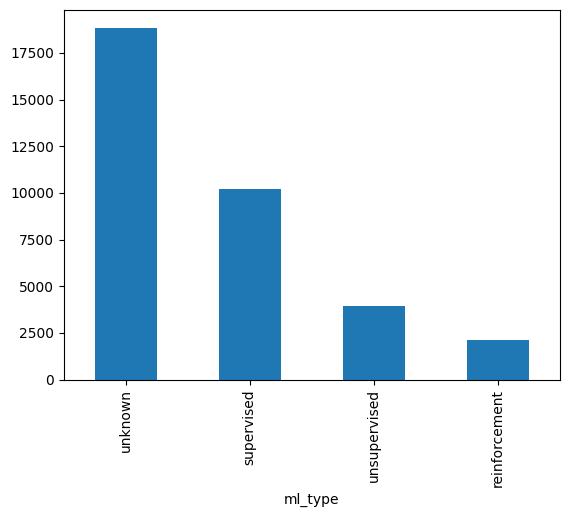

In [23]:
# Plot frequency of ML categories across all abstracts
df["ml_type"].explode().value_counts().plot(kind="bar")

In [24]:
# Sample of abstracts that were classified as "unknown"
# Should analyze to improve keyword sets
df[df["ml_type"].apply(lambda x: x == ["unknown"])].sample(2)


,query_id,eid,doi,title,abstract,clean_abs,is_supervised,is_unsupervised,is_reinforcement,ml_type
26740,ml_production_optimization,2-s2.0-85152192832,NaN,Offshore wind farm wake modelling using deep f...,© 2021 WindEurope. All Rights Reserved.Offshor...,© 2021 WindEurope. All Rights Reserved.Offshor...,False,False,False,[unknown]
30133,ml_robotics_production,2-s2.0-85082922532,NaN,Applying vision based predictive modelling for...,Copyright © by the paper's authors. Use permit...,Copyright © by the paper's authors. Use permit...,False,False,False,[unknown]


### Notes on Keyword-Based Classification

The keyword approach provides a simple first pass, but it has clear limitations:
- Many abstracts are labeled **unknown** because keywords may be absent, implicit, or expressed differently.
- Some methods overlap terminology (e.g., “semi-supervised”), which can lead to misclassification.
- Context is ignored, so the presence of a term does not guarantee it is the main ML method.

These limitations explain the large number of “unknown” cases and motivate using a more robust model-based classifier later.

## Snorkel

In [7]:
# Snorkel imports
from snorkel.labeling import labeling_function
from snorkel.labeling.model import LabelModel
from snorkel.labeling import PandasLFApplier

ABSTAIN = -1


In [33]:
# Regex helper for exact word or phrase matching

def has_term(text, term):
    pattern = r"\b" + re.escape(term) + r"\b"
    return re.search(pattern, text) is not None


In [34]:
# Supervised labeling functions with word boundaries
SUP = 1
NOT_SUP = 0

@labeling_function()
def lf_kw_supervised(x):
    return SUP if x.is_supervised else ABSTAIN

supervised_terms = [
    "supervised learning",
    "classification",
    "regression",
    "labeled data",
    "labeled dataset"
]

@labeling_function()
def lf_supervised_terms(x):
    txt = (x.clean_abs or "").lower()
    return SUP if any(has_term(txt, t) for t in supervised_terms) else ABSTAIN

@labeling_function()
def lf_not_supervised(x):
    txt = (x.clean_abs or "").lower()
    cond = has_term(txt, "clustering") and not any(has_term(txt, t) for t in ["classification", "regression"])
    return NOT_SUP if cond else ABSTAIN

@labeling_function()
def lf_title_supervised(x):
    t = (x.title or "").lower()
    cond = any(has_term(t, t2) for t2 in ["classification", "regression", "supervised"])
    return SUP if cond else ABSTAIN

lfs_supervised = [
    lf_kw_supervised,
    lf_supervised_terms,
    lf_not_supervised,
    lf_title_supervised,
]


In [35]:
# Apply supervised LFs and train LabelModel
applier_sup = PandasLFApplier(lfs=lfs_supervised)
L_sup = applier_sup.apply(df=df)

label_model_sup = LabelModel(cardinality=2, verbose=True)
label_model_sup.fit(L_train=L_sup, n_epochs=500, log_freq=50, seed=42)

df["p_supervised"] = label_model_sup.predict_proba(L_sup)[:, 1]
df["y_supervised"] = (df["p_supervised"] >= 0.5).astype(int)


100%|██████████| 32714/32714 [00:03<00:00, 9237.29it/s]
INFO:root:Computing O...
INFO:root:Estimating \mu...
  0%|          | 0/500 [00:00<?, ?epoch/s]INFO:root:[0 epochs]: TRAIN:[loss=0.171]
INFO:root:[50 epochs]: TRAIN:[loss=0.022]
INFO:root:[100 epochs]: TRAIN:[loss=0.003]
INFO:root:[150 epochs]: TRAIN:[loss=0.000]
INFO:root:[200 epochs]: TRAIN:[loss=0.000]
 42%|████▏     | 209/500 [00:00<00:00, 2084.96epoch/s]INFO:root:[250 epochs]: TRAIN:[loss=0.000]
INFO:root:[300 epochs]: TRAIN:[loss=0.000]
INFO:root:[350 epochs]: TRAIN:[loss=0.000]
INFO:root:[400 epochs]: TRAIN:[loss=0.000]
100%|██████████| 500/500 [00:00<00:00, 2104.18epoch/s]
INFO:root:Finished Training


In [36]:
# Unsupervised labeling functions with word boundaries
UNSUP = 1
NOT_UNSUP = 0

@labeling_function()
def lf_kw_unsupervised(x):
    return UNSUP if x.is_unsupervised else ABSTAIN

unsupervised_terms = [
    "unsupervised learning",
    "clustering",
    "k-means",
    "dimensionality reduction",
    "pca",
    "autoencoder"
]

@labeling_function()
def lf_unsupervised_terms(x):
    txt = (x.clean_abs or "").lower()
    return UNSUP if any(has_term(txt, t) for t in unsupervised_terms) else ABSTAIN

@labeling_function()
def lf_not_unsupervised(x):
    txt = (x.clean_abs or "").lower()
    cond = any(has_term(txt, t) for t in ["labeled data", "supervised learning"])
    return NOT_UNSUP if cond else ABSTAIN

@labeling_function()
def lf_title_unsupervised(x):
    t = (x.title or "").lower()
    cond = any(has_term(t, t2) for t2 in ["clustering", "unsupervised"])
    return UNSUP if cond else ABSTAIN

lfs_unsup = [
    lf_kw_unsupervised,
    lf_unsupervised_terms,
    lf_not_unsupervised,
    lf_title_unsupervised,
]


In [37]:
# Apply unsupervised LFs and train LabelModel
applier_unsup = PandasLFApplier(lfs=lfs_unsup)
L_unsup = applier_unsup.apply(df=df)

label_model_unsup = LabelModel(cardinality=2, verbose=True)
label_model_unsup.fit(L_train=L_unsup, n_epochs=500, log_freq=50, seed=42)

df["p_unsupervised"] = label_model_unsup.predict_proba(L_unsup)[:, 1]
df["y_unsupervised"] = (df["p_unsupervised"] >= 0.5).astype(int)


100%|██████████| 32714/32714 [00:04<00:00, 7177.85it/s]
INFO:root:Computing O...
INFO:root:Estimating \mu...
  0%|          | 0/500 [00:00<?, ?epoch/s]INFO:root:[0 epochs]: TRAIN:[loss=0.018]
INFO:root:[50 epochs]: TRAIN:[loss=0.006]
INFO:root:[100 epochs]: TRAIN:[loss=0.005]
INFO:root:[150 epochs]: TRAIN:[loss=0.004]
INFO:root:[200 epochs]: TRAIN:[loss=0.003]
 42%|████▏     | 212/500 [00:00<00:00, 2110.94epoch/s]INFO:root:[250 epochs]: TRAIN:[loss=0.001]
INFO:root:[300 epochs]: TRAIN:[loss=0.000]
INFO:root:[350 epochs]: TRAIN:[loss=0.000]
INFO:root:[400 epochs]: TRAIN:[loss=0.000]
100%|██████████| 500/500 [00:00<00:00, 2122.74epoch/s]
INFO:root:Finished Training


In [38]:
# Reinforcement learning labeling functions with word boundaries
RL = 1
NOT_RL = 0

@labeling_function()
def lf_kw_reinforcement(x):
    return RL if x.is_reinforcement else ABSTAIN

rl_terms = [
    "reinforcement learning",
    "agent",
    "reward",
    "policy gradient",
    "q-learning",
    "markov decision process",
    "mdp",
    "value function",
    "actor-critic"
]

@labeling_function()
def lf_rl_terms(x):
    txt = (x.clean_abs or "").lower()
    return RL if any(has_term(txt, t) for t in rl_terms) else ABSTAIN

@labeling_function()
def lf_not_rl(x):
    txt = (x.clean_abs or "").lower()
    cond = has_term(txt, "clustering") and not has_term(txt, "reward")
    return NOT_RL if cond else ABSTAIN

@labeling_function()
def lf_title_rl(x):
    t = (x.title or "").lower()
    return RL if any(has_term(t, t2) for t2 in ["reinforcement learning", "policy learning"]) else ABSTAIN

lfs_rl = [
    lf_kw_reinforcement,
    lf_rl_terms,
    lf_not_rl,
    lf_title_rl,
]


In [39]:
# Apply RL LFs and train LabelModel
applier_rl = PandasLFApplier(lfs=lfs_rl)
L_rl = applier_rl.apply(df=df)

label_model_rl = LabelModel(cardinality=2, verbose=True)
label_model_rl.fit(L_train=L_rl, n_epochs=500, log_freq=50, seed=42)

df["p_reinforcement"] = label_model_rl.predict_proba(L_rl)[:, 1]
df["y_reinforcement"] = (df["p_reinforcement"] >= 0.5).astype(int)


100%|██████████| 32714/32714 [00:05<00:00, 6126.28it/s]
INFO:root:Computing O...
INFO:root:Estimating \mu...
  0%|          | 0/500 [00:00<?, ?epoch/s]INFO:root:[0 epochs]: TRAIN:[loss=0.011]
INFO:root:[50 epochs]: TRAIN:[loss=0.005]
INFO:root:[100 epochs]: TRAIN:[loss=0.005]
INFO:root:[150 epochs]: TRAIN:[loss=0.005]
INFO:root:[200 epochs]: TRAIN:[loss=0.004]
 42%|████▏     | 211/500 [00:00<00:00, 2108.25epoch/s]INFO:root:[250 epochs]: TRAIN:[loss=0.002]
INFO:root:[300 epochs]: TRAIN:[loss=0.001]
INFO:root:[350 epochs]: TRAIN:[loss=0.000]
INFO:root:[400 epochs]: TRAIN:[loss=0.000]
100%|██████████| 500/500 [00:00<00:00, 2122.46epoch/s]
INFO:root:Finished Training


In [40]:
# Basic label counts and dataset size
label_cols = ["y_supervised", "y_unsupervised", "y_reinforcement"]

n_total = len(df)
print("Total rows:", n_total)
print()

print("Positive counts per label:")
print(df[label_cols].sum())
print()

print("Share of positives per label:")
print((df[label_cols].sum() / n_total).round(3))


Total rows: 32714

Positive counts per label:
y_supervised       32197
y_unsupervised     32714
y_reinforcement    32714
dtype: int64

Share of positives per label:
y_supervised       0.984
y_unsupervised     1.000
y_reinforcement    1.000
dtype: float64


In [ ]:
# Check LF firing rates
for lf in lfs_unsup:  # test unsupervised first, since it's 100% positive
    name = lf.name
    preds = L_unsup[:, lfs_unsup.index(lf)]
    print(name, "→",
          (preds == 1).mean(), "(positive rate)",
          (preds == 0).mean(), "(negative)",
          (preds == -1).mean(), "(abstain)")


lf_kw_unsupervised → 0.12059057284343094 (positive rate) 0.0 (negative) 0.879409427156569 (abstain)
lf_unsupervised_terms → 0.06018829858776059 (positive rate) 0.0 (negative) 0.9398117014122394 (abstain)
lf_not_unsupervised → 0.0 (positive rate) 0.019013266491410406 (negative) 0.9809867335085896 (abstain)
lf_title_unsupervised → 0.0118603655927126 (positive rate) 0.0 (negative) 0.9881396344072874 (abstain)


## Training a Multi-Label ML-Method Classifier Using Keyword Pseudo-Labels

- The keyword-based approach provides noisy but useful initial labels for each article (e.g., supervised / unsupervised / reinforcement).  
- In the following steps, we use these pseudo-labels to train a **multi-label transformer model** (e.g., SciBERT or DistilBERT) on the abstracts. 
- This allows the model to learn richer linguistic patterns and produce more accurate classifications than the raw keyword method, while requiring **no manual labeling up front**.


In [22]:
import torch
print(torch.__version__)

2.9.1+cu128


In [ ]:
from datasets import Dataset
import numpy as np

# Keyword labels
# label_cols = ["is_supervised", "is_unsupervised", "is_reinforcement"]

# Snorkel labels
label_cols = ["y_supervised", "y_unsupervised", "y_reinforcement"]

# Keep only rows that have at least one positive label (optional but often useful)
df_model = df.copy()
mask_any_label = df_model[label_cols].sum(axis=1) > 0
df_model = df_model[mask_any_label].reset_index(drop=True)

print(df_model[label_cols].mean())  # quick check of label frequencies

dataset = Dataset.from_pandas(df_model[["clean_abs"] + label_cols])

# Train/validation split
splits = dataset.train_test_split(test_size=0.2, seed=42)
train_ds = splits["train"]
val_ds = splits["test"]



/cluster/home/mbergst/.venvs/ml-catalogue/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


is_supervised       0.735786
is_unsupervised     0.284632
is_reinforcement    0.151227
dtype: float64


In [24]:
# Ensure scibert directory exists
scibert_path = processed_abstracts_path / "scibert_2"
scibert_path.mkdir(parents=True, exist_ok=True)

# Save datasets
train_path = scibert_path / "train_ds.csv"
val_path = scibert_path / "val_ds.csv"

train_ds.to_csv(train_path, index=False)
val_ds.to_csv(val_path, index=False)

print(f"Saved train_ds to: {train_path}")
print(f"Saved val_ds to:   {val_path}")

Creating CSV from Arrow format: 100%|██████████| 3/3 [00:00<00:00, 47.21ba/s]

Saved train_ds to: ../../data/processed/abstracts/scibert_2/train_ds.csv
Saved val_ds to:   ../../data/processed/abstracts/scibert_2/val_ds.csv


In [25]:
train_ds.to_pandas().head()


,clean_abs,is_supervised,is_unsupervised,is_reinforcement
0,© 2025 Elsevier LtdSurface wastewater originat...,True,False,False
1,Crop production management is essential for op...,False,False,True
2,© 2025 The AuthorsBattery technologies (BTs) a...,False,False,True
3,Optimal control and process optimization of as...,True,False,False
4,"© 2020 ACM.Nowadays, agriculture around the wo...",True,False,False


In [26]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = "allenai/scibert_scivocab_uncased"  # or "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_name)

label_cols = ["is_supervised", "is_unsupervised", "is_reinforcement"]

# Add a single multi-label 'labels' column
def add_labels(example):
    example["labels"] = [float(example[c]) for c in label_cols]
    return example

train_ds_l = train_ds.map(add_labels)
val_ds_l   = val_ds.map(add_labels)

def tokenize_batch(batch):
    return tokenizer(
        batch["clean_abs"],
        padding="max_length",
        truncation=True,
        max_length=512,
    )

train_ds_tok = train_ds_l.map(tokenize_batch, batched=True)
val_ds_tok   = val_ds_l.map(tokenize_batch, batched=True)

def set_format(ds):
    return ds.with_format(
        type="torch",
        columns=["input_ids", "attention_mask", "labels"],
    )

train_ds_tok = set_format(train_ds_tok)
val_ds_tok   = set_format(val_ds_tok)

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(label_cols),
    problem_type="multi_label_classification",
)


Map: 100%|██████████| 2772/2772 [00:00<00:00, 3858.01 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
# Compute average number of tokens per abstract using the tokenizer

lengths = []

for text in df["clean_abs"].tolist():
    enc = tokenizer(
        text,
        truncation=True,
        max_length=2048,
    )
    lengths.append(len(enc["input_ids"]))

avg_len = sum(lengths) / len(lengths)
max_len = max(lengths)
min_len = min(lengths)

print(f"Average token length: {avg_len:.2f}")
print(f"Min tokens: {min_len}, Max tokens: {max_len}")


Average token length: 276.98
Min tokens: 27, Max tokens: 2048


In [28]:
# Count how many abstracts exceed various token-length thresholds

thresholds = [256, 512, 768, 1024, 1500]

lengths = []
for text in df["clean_abs"].tolist():
    enc = tokenizer(text, truncation=False)   # do NOT truncate → get true length
    lengths.append(len(enc["input_ids"]))

results = {}
for t in thresholds:
    results[t] = sum(l > t for l in lengths)

print("Token length distribution:")
for t, count in results.items():
    print(f" > {t:4d} tokens : {count} abstracts")

# Optional: also show % of dataset
n = len(lengths)
print("\nPercentages:")
for t, count in results.items():
    print(f" > {t:4d} tokens : {count/n*100:.2f}%")


Token length distribution:
 >  256 tokens : 17172 abstracts
 >  512 tokens : 922 abstracts
 >  768 tokens : 173 abstracts
 > 1024 tokens : 77 abstracts
 > 1500 tokens : 6 abstracts

Percentages:
 >  256 tokens : 52.49%
 >  512 tokens : 2.82%
 >  768 tokens : 0.53%
 > 1024 tokens : 0.24%
 > 1500 tokens : 0.02%


In [29]:
# Check cuda version etc for debugging

print(torch.version.cuda)
print(torch.cuda.get_device_name())
print(torch.cuda.get_device_capability())
print(torch.cuda.get_arch_list())

12.8
NVIDIA A100-SXM4-80GB
(8, 0)
['sm_70', 'sm_75', 'sm_80', 'sm_86', 'sm_90', 'sm_100', 'sm_120']


In [30]:
from transformers import TrainingArguments, Trainer
from sklearn.metrics import f1_score, precision_score, recall_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = 1 / (1 + np.exp(-logits))           # sigmoid
    preds = (probs >= 0.5).astype(int)

    # Flatten over labels
    return {
        "f1_micro": f1_score(labels, preds, average="micro", zero_division=0),
        "f1_macro": f1_score(labels, preds, average="macro", zero_division=0),
        "precision_micro": precision_score(labels, preds, average="micro", zero_division=0),
        "recall_micro": recall_score(labels, preds, average="micro", zero_division=0),
    }

training_args = TrainingArguments(
    output_dir="./ml_type_model",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1_micro",
    logging_steps=50,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds_tok,
    eval_dataset=val_ds_tok,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()


/tmp/ipykernel_1423301/310402851.py:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1 Micro,F1 Macro,Precision Micro,Recall Micro
1,0.031900,0.031257,0.989995,0.987170,0.991980,0.988018
2,0.009400,0.023125,0.993560,0.991881,0.991736,0.995392
3,0.003100,0.019975,0.994784,0.993657,0.993564,0.996006


TrainOutput(global_step=2079, training_loss=0.0495304960314903, metrics={'train_runtime': 731.5669, 'train_samples_per_second': 45.47, 'train_steps_per_second': 2.842, 'total_flos': 8752204727304192.0, 'train_loss': 0.0495304960314903, 'epoch': 3.0})

In [31]:
# Tune thresholds based on validation set

logits_val, labels_val = trainer.predict(val_ds_tok)[:2]
probs_val = 1 / (1 + np.exp(-logits_val))

best_thresholds = {}

for i, col in enumerate(label_cols):
    best_f1 = 0.0
    best_t = 0.5
    for t in np.linspace(0.1, 0.9, 17):  # prøv thresholds fra 0.1 til 0.9
        preds = (probs_val[:, i] >= t).astype(int)
        f1 = f1_score(labels_val[:, i], preds, zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_t = t
    best_thresholds[col] = best_t

print("Best thresholds:", best_thresholds)


Best thresholds: {'is_supervised': np.float64(0.1), 'is_unsupervised': np.float64(0.75), 'is_reinforcement': np.float64(0.15000000000000002)}


In [32]:
def predict_ml_types_batched(texts, trainer, threshold=0.5, batch_size=64, max_length=512):
    all_preds = []
    all_probs = []

    model = trainer.model
    model.eval()

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]

        enc = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors="pt",
        )
        enc = {k: v.to(model.device) for k, v in enc.items()}

        with torch.no_grad():
            logits = model(**enc).logits

        probs = torch.sigmoid(logits).cpu().numpy()
        preds = (probs >= threshold).astype(int)

        all_probs.append(probs)
        all_preds.append(preds)

    all_probs = np.vstack(all_probs)
    all_preds = np.vstack(all_preds)
    return all_preds, all_probs


texts = df["clean_abs"].tolist()
preds, probs = predict_ml_types_batched(texts, trainer, batch_size=64, threshold=0.5)

for i, col in enumerate(label_cols):
    df[f"pred_{col}"] = preds[:, i]


In [33]:
for i, col in enumerate(label_cols):
    df[f"pred_{col}"] = preds[:, i]

pred_cols = [f"pred_{c}" for c in label_cols]
cols_to_save = [
    "query_id", "eid", "doi", "title", "abstract", "clean_abs",
] + label_cols + pred_cols

save_path = scibert_path / "abstracts_with_predictions.csv"
df[cols_to_save].to_csv(save_path, index=False)

print(f"Saved predictions to: {save_path}")

Saved predictions to: ../../data/processed/abstracts/scibert_2/abstracts_with_predictions.csv


## Analyze Scibert Predictions

In [34]:
pred_path = Path("../../data/processed/abstracts/scibert_2/abstracts_with_predictions.csv")

pred_cols = ["pred_is_supervised","pred_is_unsupervised","pred_is_reinforcement"]

In [35]:
df = pd.read_csv(pred_path)
df.head()

,query_id,eid,doi,title,abstract,clean_abs,is_supervised,is_unsupervised,is_reinforcement,pred_is_supervised,pred_is_unsupervised,pred_is_reinforcement
0,ml_anomaly_detection_production,2-s2.0-105018574505,10.1016/j.measurement.2025.119261,Distillation anomaly and fault detection based...,© 2025 The Author(s)The detection of anomalies...,The detection of anomalies in production proce...,True,True,False,1,1,0
1,ml_anomaly_detection_production,2-s2.0-105019192533,10.1007/978-3-032-06118-8_30,From Lab to Factory: Pitfalls and Guidelines f...,"© The Author(s), under exclusive license to Sp...",", under exclusive license to Springer Nature S...",True,True,False,1,1,0
2,ml_anomaly_detection_production,2-s2.0-105016669957,10.1007/978-3-032-04200-2_5,Intelligent Defect Detection for Manufacturing...,"© The Author(s), under exclusive license to Sp...",", under exclusive license to Springer Nature S...",True,True,False,1,1,0
3,ml_anomaly_detection_production,2-s2.0-85218693791,10.1038/s41598-025-90810-w,Hybrid machine learning framework for predicti...,© The Author(s) 2025.The critical necessity fo...,2025.The critical necessity for sophisticated ...,True,True,False,1,1,0
4,ml_anomaly_detection_production,2-s2.0-105018301117,10.1016/j.comnet.2025.111753,BGP anomaly detection using the raw internet t...,© 2025 The AuthorsThe Border Gateway Protocol ...,© 2025 The AuthorsThe Border Gateway Protocol ...,False,True,False,0,1,0


In [36]:
df[pred_cols].mean()

pred_is_supervised       0.787186
pred_is_unsupervised     0.138503
pred_is_reinforcement    0.099927
dtype: float64

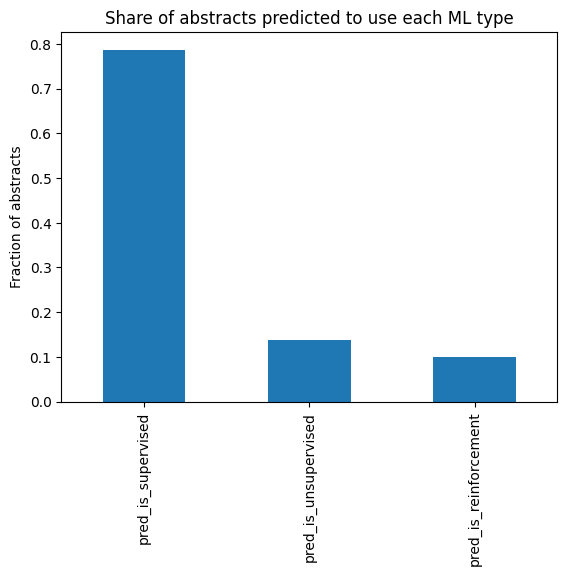

In [37]:
df[pred_cols].mean().plot(kind="bar")
plt.title("Share of abstracts predicted to use each ML type")
plt.ylabel("Fraction of abstracts")
plt.show()

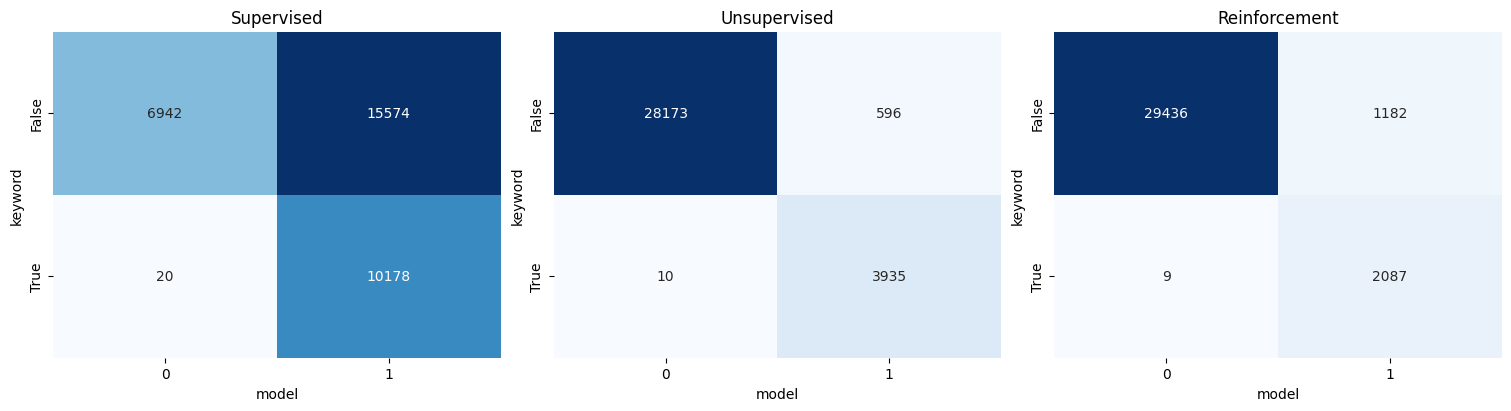

In [38]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4), constrained_layout=True)

for ax, col in zip(axes, label_cols):
    ctab = pd.crosstab(df[col], df[f"pred_{col}"], rownames=["keyword"], colnames=["model"])
    
    sns.heatmap(
        ctab,
        annot=True,
        fmt="d",
        cmap="Blues",
        cbar=False,
        ax=ax
    )
    ax.set_title(col.replace("is_", "").capitalize())

plt.show()


In [39]:
# Small per-label stats
for col in label_cols:
    pred = df[f"pred_{col}"]
    true = df[col]

    tp = ((true == 1) & (pred == 1)).sum()
    fp = ((true == 0) & (pred == 1)).sum()
    fn = ((true == 1) & (pred == 0)).sum()
    tn = ((true == 0) & (pred == 0)).sum()

    print(
        f"\n=== {col} ===\n"
        f"TP: {tp}\nFP: {fp}\nFN: {fn}\nTN: {tn}\n"
        f"Precision: {tp/(tp+fp+1e-9):.3f}\n"
        f"Recall:    {tp/(tp+fn+1e-9):.3f}\n"
    )



=== is_supervised ===
TP: 10178
FP: 15574
FN: 20
TN: 6942
Precision: 0.395
Recall:    0.998


=== is_unsupervised ===
TP: 3935
FP: 596
FN: 10
TN: 28173
Precision: 0.868
Recall:    0.997


=== is_reinforcement ===
TP: 2087
FP: 1182
FN: 9
TN: 29436
Precision: 0.638
Recall:    0.996



In [40]:
# Extract a few rows where the model disagrees with keyword labels (only among keyword-labeled rows)

mask_labeled = df[label_cols].sum(axis=1) > 0
mask_disagree = (df[[f"pred_{c}" for c in label_cols]].values != df[label_cols].values).any(axis=1)

df_mismatch = df[mask_labeled & mask_disagree]

df_mismatch.sample(10)[
    ["doi", "title", "clean_abs"] 
    + label_cols 
    + [f"pred_{c}" for c in label_cols]
]


,doi,title,clean_abs,is_supervised,is_unsupervised,is_reinforcement,pred_is_supervised,pred_is_unsupervised,pred_is_reinforcement
31743,10.1109/TCYB.2014.2378056,A new multivariate approach for prognostics ba...,© 2013 IEEE.Prognostics is a core process of p...,True,True,False,0,1,0
27698,10.1007/s11625-017-0521-6,Assessment of mitigation strategies as tools f...,2017.Although the world understands the possib...,False,True,True,0,0,1
28,10.3390/electronics14152930,Correction: Anomaly Detection in 6G Networks U...,© 2025 by the authors.In the original publicat...,True,False,True,0,0,1
16503,10.1109/ICSPC47137.2019.9068081,Anomaly analysis for the classification purpos...,"© 2019 IEEE.Nowadays, along with network devel...",True,False,False,1,1,0
330,NaN,Vibration and Acoustic Resonance Spectrometry ...,© 2022 Society of Machinery Failure Prevention...,True,True,False,0,1,0
13672,10.2118/197355-ms,Advanced analytics for predictive maintenance ...,"© 2019, Society of Petroleum EngineersThe curr...",True,False,False,1,1,0
6076,NaN,Procedia Computer Science,The proceedings contain 210 papers. The topics...,False,True,True,1,1,1
3523,10.3390/ma18112604,High-Cycle Fatigue Life Prediction of Additive...,© 2025 by the authors.This study established a...,True,False,False,1,1,0
10334,10.1109/ACCESS.2025.3611009,Anomaly Detection in Railway Tracks Using Hybr...,© 2013 IEEE.Efficient railway track maintenanc...,True,True,False,0,1,0
30529,10.1109/AUTOCOM64127.2025.10956372,Tool Condition Prediction in High-Speed Millin...,© 2025 IEEE.Highly effective and reliable high...,True,False,True,1,0,0


In [41]:
# Compare prediction counts for rows used in training vs rows not used in training

# Identify which rows were used for training (those with at least one keyword-label = 1)
mask_train = df[label_cols].sum(axis=1) > 0
mask_not_train = ~mask_train

# Count predicted positives per class for train rows
pred_cols = [f"pred_{c}" for c in label_cols]

pred_counts_train = df[mask_train][pred_cols].sum()
pred_counts_not_train = df[mask_not_train][pred_cols].sum()

print("=== Predictions on TRAINED rows ===")
print(pred_counts_train)
print("\n=== Predictions on NON-TRAINED rows ===")
print(pred_counts_not_train)


=== Predictions on TRAINED rows ===
pred_is_supervised       10187
pred_is_unsupervised      3952
pred_is_reinforcement     2090
dtype: int64

=== Predictions on NON-TRAINED rows ===
pred_is_supervised       15565
pred_is_unsupervised       579
pred_is_reinforcement     1179
dtype: int64
